In [125]:
import tensorflow as tf
import cv2
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [126]:
# Check TensorFlow version and devices
print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())

# Test OpenCV installation
print("OpenCV version:", cv2.__version__)

TensorFlow version: 2.18.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
OpenCV version: 4.10.0


In [127]:
# Read the jaffed file data
unprocessed_jaffed_df = pd.read_csv("jaffed_data.txt", delim_whitespace=True, header=0)

#Find the column with the highest valued emotion in each row
processed_jaffed_df = unprocessed_jaffed_df.drop(columns=['PIC', '#'])
max_columns = processed_jaffed_df.idxmax(axis=1)

# Store the results in a new dataframe and pair with proper file name
jaffed_df = pd.DataFrame({
    'emotion': max_columns,
    'pixels': [f'jaffedbase/{unprocessed_jaffed_df.loc[index, "#"]}.tiff' for index in range(len(unprocessed_jaffed_df))]
})

C:\Users\wowen\AppData\Local\Temp\ipykernel_14468\945279305.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  unprocessed_jaffed_df = pd.read_csv("jaffed_data.txt", delim_whitespace=True, header=0)


In [128]:
# Function to read a .tiff image using tifffile and convert to space-separated pixel values
def image_to_pixel_string(image_path):
    # Read the .tiff image using tifffile, turn to 1D flattened array
    img_array = tifffile.imread(image_path)
    flattened = img_array.flatten()

    # Convert the flattened array to a space-separated string of pixel values
    # Done to match format of the CKextended dataset
    pixel_str = ' '.join(map(str, flattened))

    return pixel_str

In [129]:
# Populate the 'image' field with space-separated pixel values

# Iterate over the image column and insert pixel values as space-separated strings
for index, row in jaffed_df.iterrows():
    pixel_string = image_to_pixel_string(row['pixels'])
    if pixel_string:
        jaffed_df.at[index, 'pixels'] = pixel_string


# Display the new dataframe
print(jaffed_df)

    emotion                                             pixels
0       HAP  155 156 160 158 158 156 156 158 149 161 154 15...
1       HAP  163 168 169 171 165 167 162 155 166 165 165 17...
2       HAP  163 155 166 168 158 160 169 168 168 166 159 16...
3       HAP  156 158 159 153 153 152 158 158 153 154 157 15...
4       HAP  166 157 165 162 174 165 173 167 167 164 164 17...
..      ...                                                ...
208     DIS  59 56 57 55 50 54 55 58 61 61 64 59 61 65 75 7...
209     ANG  53 63 63 55 51 55 54 54 59 53 63 60 58 65 67 6...
210     SUR  36 32 35 42 40 36 45 45 45 46 46 44 46 45 48 4...
211     FEA  30 31 34 28 38 40 40 47 40 42 53 56 61 61 64 5...
212     FEA  42 42 38 45 41 42 46 40 31 38 40 42 45 37 45 4...

[213 rows x 2 columns]


In [130]:
# Find the Unique values in the emotion column
unique_emotions = jaffed_df['emotion'].unique()
print("Unique emotions in the dataset:", unique_emotions)

Unique emotions in the dataset: ['HAP' 'SAD' 'SUR' 'ANG' 'DIS' 'FEA']


In [131]:
# Map values to represent the same format as the CK+ dataset
emotion_mapping = {
    "ANG": 0,
    "DIS": 1,
    "FEA": 2,
    "HAP": 3,
    "SAD": 4,
    "SUR": 5
}
jaffed_df['emotion'] = jaffed_df['emotion'].map(emotion_mapping)
print(jaffed_df)
#Contains 256x256 flattened pixel array

     emotion                                             pixels
0          3  155 156 160 158 158 156 156 158 149 161 154 15...
1          3  163 168 169 171 165 167 162 155 166 165 165 17...
2          3  163 155 166 168 158 160 169 168 168 166 159 16...
3          3  156 158 159 153 153 152 158 158 153 154 157 15...
4          3  166 157 165 162 174 165 173 167 167 164 164 17...
..       ...                                                ...
208        1  59 56 57 55 50 54 55 58 61 61 64 59 61 65 75 7...
209        0  53 63 63 55 51 55 54 54 59 53 63 60 58 65 67 6...
210        5  36 32 35 42 40 36 45 45 45 46 46 44 46 45 48 4...
211        2  30 31 34 28 38 40 40 47 40 42 53 56 61 61 64 5...
212        2  42 42 38 45 41 42 46 40 31 38 40 42 45 37 45 4...

[213 rows x 2 columns]


In [132]:
#Load the CK+ Extended Dataset
CK_df = pd.read_csv("ckextended.csv", header=0)
CK_df = CK_df.drop(columns=['Usage'])
print(CK_df)
#Contains 48x48 flattened pixel array

     emotion                                             pixels
0          6  36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...
1          6  88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...
2          6  9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...
3          6  104 106 108 104 95 50 60 61 58 83 126 133 139 ...
4          6  68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...
..       ...                                                ...
915        5  87 86 88 92 92 127 231 248 251 253 254 254 254...
916        5  21 24 26 28 27 28 30 8 0 0 0 0 0 0 1 4 37 42 4...
917        5  76 40 31 38 28 34 38 36 41 36 46 38 44 26 45 5...
918        5  114 87 16 29 17 25 30 34 37 35 45 93 63 80 73 ...
919        5  101 102 99 96 98 42 23 18 15 17 27 34 17 24 29...

[920 rows x 2 columns]


In [133]:
#function that takes a space seperated flattened image and converts to a new size
def resize_flattened_image(flat_array:str, original_size:tuple, target_size:tuple):
    # convert to array
    flat_array = np.fromstring(flat_array, sep=" ", dtype=np.uint8)
    #resize
    reshaped_image = flat_array.reshape(original_size)
    resized_image = cv2.resize(reshaped_image, target_size, interpolation=cv2.INTER_LINEAR)
    resized_flattened = resized_image.flatten().astype(np.uint8)
    #convert back to str
    resized_string = " ".join(map(str, resized_flattened))
    
    return resized_string

In [134]:
CK_df['pixels'] = CK_df['pixels'].apply(lambda x: resize_flattened_image(x, (48,48), (256,256)))
print(CK_df)

     emotion                                             pixels
0          6  36 36 36 36 37 38 38 38 38 38 37 36 35 35 33 3...
1          6  88 88 88 86 83 80 78 75 69 59 48 38 27 19 16 1...
2          6  9 9 9 8 6 5 4 3 2 3 3 3 3 4 5 5 6 6 7 6 5 4 3 ...
3          6  104 104 104 104 105 105 105 106 106 107 107 10...
4          6  68 68 68 68 69 70 71 72 71 70 70 69 68 67 67 6...
..       ...                                                ...
915        5  87 87 87 87 86 86 86 86 86 86 87 87 88 88 89 8...
916        5  21 21 21 21 22 22 23 24 24 24 25 25 26 26 26 2...
917        5  76 76 76 70 64 57 50 43 39 37 36 34 32 31 32 3...
918        5  114 114 114 110 105 99 94 89 80 67 54 40 27 16...
919        5  101 101 101 101 101 101 102 102 102 101 100 10...

[920 rows x 2 columns]


In [135]:
# Load OpenCV's pre-trained Haar Cascade
cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cascade_path)

In [141]:
# Detect the faces in a image, using Haar Cascades
def detect_faces(pixels):
    # Convert pixels to image arr
    image = np.fromstring(pixels, sep=" ", dtype=np.uint8).reshape((256,256))
    # Detect and draw rectangles
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)  # Blue rectangle
    
    return image, faces

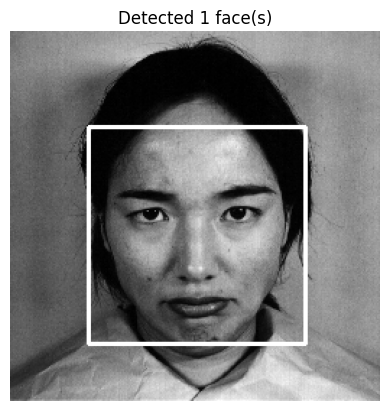

In [148]:
# Test with an example image
test_image = jaffed_df.loc[120, 'pixels']
detected_image, faces = detect_faces(test_image)

# Display the results
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
plt.axis("off")
plt.title(f"Detected {len(faces)} face(s)")
plt.show()

Face Detection Works!
now we can modify the logic above to start building our tensor flow layers.
We'll modify this so it outputs the cropped facial region, that way only the facial region gets fed into the next layer

In [ ]:
class FaceDetectionLayer(tf.keras.layers.Layer):
    def __init__(self, face_cascade_path, target_size=(256, 256), face_size=(64, 64), **kwargs):
        super(FaceDetectionLayer, self).__init__(**kwargs)
        self.target_size = target_size
        self.face_size = face_size
        self.face_cascade = cv2.CascadeClassifier(face_cascade_path)  # Load Haar Cascade

    def detect_faces(self, pixels):
        # Convert pixels to image array
        image = np.fromstring(pixels, sep=" ", dtype=np.uint8).reshape(self.target_size)

        # Detect faces
        faces = self.face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Crop and resize each detected face
        cropped_faces = []
        for (x, y, w, h) in faces:
            face_region = image[y:y+h, x:x+w]  # Crop face
            resized_face = cv2.resize(face_region, self.face_size, interpolation=cv2.INTER_LINEAR)
            cropped_faces.append(resized_face)

        # If no faces are detected, add a blank face
        if not cropped_faces:
            cropped_faces.append(np.zeros(self.face_size, dtype=np.uint8))

        # Return all cropped faces
        return np.stack(cropped_faces)

    def call(self, inputs):
        def process_single_sample(pixel_string):
            # Detect faces for a single sample
            cropped_faces = self.detect_faces(pixel_string.numpy().decode("utf-8"))
            return cropped_faces

        # Use tf.py_function to integrate OpenCV logic with Tensorflow
        outputs = tf.map_fn(
            lambda x: tf.py_function(func=process_single_sample, inp=[x], Tout=tf.uint8),
            inputs,
            dtype=tf.uint8
        )

        return outputs

Next we build the layer we need for Skin Segmentation using a YCbCr color space